# Vectorized QMC

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/vectorized_qmc.ipynb)

In [1]:
%%capture
# @title Execute this cell to install dependancies
try:
  import google.colab
  import os
  !pip install -q qmcpy >> /dev/null
  !apt-get update && apt-get install -y --no-install-recommends texlive-latex-base texlive-fonts-recommended texlive-latex-extra cm-super dvipng
except:
  pass

import matplotlib.pyplot as plt

plt.rcParams.update({
"text.usetex": True,
"font.family": "serif",
"text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}\newcommand{\bx}{\boldsymbol{x}}"
})
!pip install scikit-learn

In [2]:
import qmcpy as qp
import numpy as np

In [3]:
from matplotlib import pyplot
%matplotlib inline
root = '.'

## LD Sequence

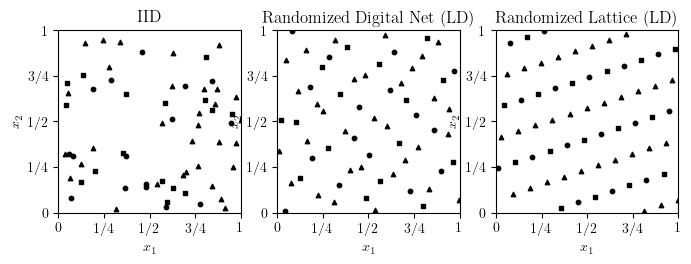

In [4]:
n = 2**6
s = 10
fig,ax = pyplot.subplots(figsize=(8,4),nrows=1,ncols=3)
for i,(dd,name) in enumerate(zip(
    [qp.IIDStdUniform(2,seed=7),qp.DigitalNetB2(2,seed=7),qp.Lattice(2,seed=7)],
    ['IID','Randomized Digital Net (LD)','Randomized Lattice (LD)'])):
    pts = dd.gen_samples(n)
    ax[i].scatter(pts[0:n//4,0],pts[0:n//4,1],color='k',marker='s',s=s)
    ax[i].scatter(pts[n//4:n//2,0],pts[n//4:n//2,1],color='k',marker='o',s=s)
    ax[i].scatter(pts[n//2:n,0],pts[n//2:n,1],color='k',marker='^',s=s)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$x_{1}$')
    ax[i].set_ylabel(r'$x_{2}$')
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,.25,.5,.75,1])
    ax[i].set_xticklabels([r'$0$',r'$1/4$',r'$1/2$',r'$3/4$',r'$1$'])
    ax[i].set_yticks([0,.25,.5,.75,1])
    ax[i].set_yticklabels([r'$0$',r'$1/4$',r'$1/2$',r'$3/4$',r'$1$'])
    ax[i].set_title(name)
if root: fig.savefig(root+'ld_seqs.pdf',transparent=True)

## Simple Example

In [5]:
def cantilever_beam_function(T,compute_flags): # T is (n x 3)
    Y = np.zeros((len(T),2),dtype=float) # (n x 2)
    l,w,t = 100,4,2
    T1,T2,T3 = T[:,0],T[:,1],T[:,2] # Python is indexed from 0
    if compute_flags[0]: # compute D. x^2 is "x**2" in Python
        Y[:,0] = 4*l**3/(T1*w*t)*np.sqrt(T2**2/t**4+T3**2/w**4)
    if compute_flags[1]: # compute S
        Y[:,1] = 600*(T2/(w*t**2)+T3/(w**2*t))
    return Y
true_measure = qp.Gaussian(
    sampler = qp.DigitalNetB2(dimension=3,seed=7),
    mean = [2.9e7,500,1000],
    covariance = np.diag([(1.45e6)**2,(100)**2,(100)**2]))
integrand = qp.CustomFun(true_measure,
    g = cantilever_beam_function,
    dimension_indv = 2)
qmc_stop_crit = qp.CubQMCNetG(integrand,
    abs_tol = 1e-3,
    rel_tol = 1e-6)
solution,data = qmc_stop_crit.integrate()
print(solution)
# [2.42575885e+00 3.74999973e+04]

[2.42575885e+00 3.74999973e+04]


## BO QEI

See the [QEI Demo in QMCPy](https://qmcpy.readthedocs.io/en/latest/demo_rst/qei-demo-for-blog.html) or the [BoTorch Acquisition documentation](https://botorch.org/docs/acquisition) for details on Bayesian Optimization using q-Expected Improvement.

In [6]:
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor,kernels

f = lambda x: np.cos(10*x)*np.exp(.2*x)+np.exp(-5*(x-.4)**2)
xplt = np.linspace(0,1,100)
yplt = f(xplt)
x = np.array([.1, .2, .4, .7, .9])
y = f(x)
ymax = y.max()

gp = GaussianProcessRegressor(kernel=kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2, 1e2)),
    n_restarts_optimizer = 16).fit(x[:,None],y)
yhatplt,stdhatplt = gp.predict(xplt[:,None],return_std=True)

tpax = 32
x0mesh,x1mesh = np.meshgrid(np.linspace(0,1,tpax),np.linspace(0,1,tpax))
post_mus = np.zeros((tpax,tpax,2),dtype=float)
post_sqrtcovs = np.zeros((tpax,tpax,2,2),dtype=float)
for j0 in range(tpax):
    for j1 in range(tpax):
        candidate = np.array([[x0mesh[j0,j1]],[x1mesh[j0,j1]]])
        post_mus[j0,j1],post_cov = gp.predict(candidate,return_cov=True)
        evals,evecs = scipy.linalg.eig(post_cov)
        post_sqrtcovs[j0,j1] = np.sqrt(np.maximum(evals.real,0))*evecs

def qei_acq_vec(x,compute_flags):
    xgauss = scipy.stats.norm.ppf(x)
    n = len(x)
    qei_vals = np.zeros((n,tpax,tpax),dtype=float)
    for j0 in range(tpax):
        for j1 in range(tpax):
            if compute_flags[j0,j1]==False: continue
            sqrt_cov = post_sqrtcovs[j0,j1]
            mu_post = post_mus[j0,j1]
            for i in range(len(x)):
                yij = sqrt_cov@xgauss[i]+mu_post
                qei_vals[i,j0,j1] = max((yij-ymax).max(),0)
    return qei_vals

qei_acq_vec_qmcpy = qp.CustomFun(
    true_measure = qp.Uniform(qp.DigitalNetB2(2,seed=7)),
    g = qei_acq_vec,
    dimension_indv = (tpax,tpax),
    parallel=False)
qei_vals,qei_data = qp.CubQMCNetG(qei_acq_vec_qmcpy,abs_tol=.025,rel_tol=0).integrate() # .0005
print(qei_data)

a = np.unravel_index(np.argmax(qei_vals,axis=None),qei_vals.shape)
xnext = np.array([x0mesh[a[0],a[1]],x1mesh[a[0],a[1]]])
fnext = f(xnext)

LDTransformData (AccumulateData Object)
    solution        [[0.06  0.079 0.072 ... 0.06  0.06  0.067]
                    [0.079 0.064 0.067 ... 0.064 0.065 0.071]
                    [0.072 0.067 0.032 ... 0.032 0.033 0.039]
                    ...
                    [0.06  0.064 0.032 ... 0.    0.001 0.007]
                    [0.06  0.065 0.033 ... 0.    0.001 0.007]
                    [0.066 0.07  0.039 ... 0.007 0.007 0.007]]
    comb_bound_low  [[0.059 0.078 0.071 ... 0.058 0.059 0.065]
                    [0.078 0.063 0.066 ... 0.063 0.064 0.07 ]
                    [0.071 0.066 0.032 ... 0.032 0.032 0.038]
                    ...
                    [0.059 0.063 0.032 ... 0.    0.001 0.006]
                    [0.059 0.064 0.032 ... 0.    0.    0.006]
                    [0.065 0.069 0.038 ... 0.006 0.006 0.006]]
    comb_bound_high [[0.061 0.08  0.073 ... 0.061 0.061 0.068]
                    [0.08  0.065 0.068 ... 0.065 0.066 0.072]
                    [0.073 0.068 0.033 

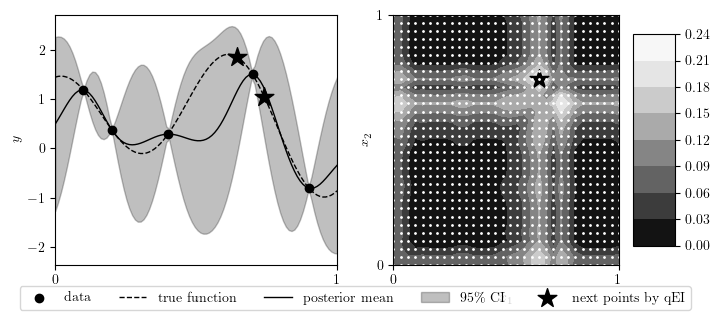

In [7]:
from matplotlib import cm
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,3.25))
ax[0].scatter(x,y,color='k',label='Query Points')
ax[0].plot(xplt,yplt,color='k',linestyle='--',label='True function',linewidth=1)
ax[0].plot(xplt,yhatplt,color='k',label='GP Mean',linewidth=1)
ax[0].fill_between(xplt,yhatplt-1.96*stdhatplt,yhatplt+1.96*stdhatplt,color='k',alpha=.25,label='95% CI')
ax[0].scatter(xnext,fnext,color='k',marker='*',s=200,zorder=10)
ax[0].set_xlim([0,1])
ax[0].set_xticks([0,1])
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
fig.legend(labels=['data','true function','posterior mean',r'95\% CI','next points by qEI'],loc='lower center',bbox_to_anchor=(.5,-.05),ncol=5)
contour = ax[1].contourf(x0mesh,x1mesh,qei_vals,cmap=cm.Greys_r)
ax[1].scatter([xnext[0]],[xnext[1]],color='k',marker='*',s=200)
fig.colorbar(contour,ax=None,shrink=1,aspect=5)
ax[1].scatter(x0mesh.flatten(),x1mesh.flatten(),color='w',s=1)
ax[1].set_xlim([0,1])
ax[1].set_xticks([0,1])
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$x_2$')
if root: fig.savefig(root+'gp.pdf',transparent=True)

## Bayesian Logistic Regression

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data',header=None)
df.columns = ['Age','1900 Year','Axillary Nodes','Survival Status']
df.loc[df['Survival Status']==2,'Survival Status'] = 0
x,y = df[['Age','1900 Year','Axillary Nodes']],df['Survival Status']
xt,xv,yt,yv = train_test_split(x,y,test_size=.33,random_state=7)

In [9]:
print(df.head(),'\n')
print(df[['Age','1900 Year','Axillary Nodes']].describe(),'\n')
print(df['Survival Status'].astype(str).describe())
print('\ntrain samples: %d test samples: %d\n'%(len(xt),len(xv)))
print('train positives %d   train negatives: %d'%(np.sum(yt==1),np.sum(yt==0)))
print(' test positives %d    test negatives: %d'%(np.sum(yv==1),np.sum(yv==0)))
xt.head()

   Age  1900 Year  Axillary Nodes  Survival Status
0   30         64               1                1
1   30         62               3                1
2   30         65               0                1
3   31         59               2                1
4   31         65               4                1 

              Age   1900 Year  Axillary Nodes
count  306.000000  306.000000      306.000000
mean    52.457516   62.852941        4.026144
std     10.803452    3.249405        7.189654
min     30.000000   58.000000        0.000000
25%     44.000000   60.000000        0.000000
50%     52.000000   63.000000        1.000000
75%     60.750000   65.750000        4.000000
max     83.000000   69.000000       52.000000 

count     306
unique      2
top         1
freq      225
Name: Survival Status, dtype: object

train samples: 205 test samples: 101

train positives 151   train negatives: 54
 test positives 74    test negatives: 27


,Age,1900 Year,Axillary Nodes
46,41,58,0
199,57,64,1
115,49,64,10
128,50,61,0
249,63,63,0


In [10]:
blr = qp.BayesianLRCoeffs(
    sampler = qp.DigitalNetB2(4,seed=7),
    feature_array = xt, # np.ndarray of shape (n,d-1)
    response_vector = yt, # np.ndarray of shape (n,)
    prior_mean = 0, # normal prior mean = (0,0,...,0)
    prior_covariance = 5) # normal prior covariance = 5I
qmc_sc = qp.CubQMCNetG(blr,
    abs_tol = .05,
    rel_tol = .5,
    error_fun = lambda s,abs_tols,rel_tols:
        np.minimum(abs_tols,np.abs(s)*rel_tols))
blr_coefs,blr_data = qmc_sc.integrate()
print(blr_data)
# LDTransformData (AccumulateData Object)
#     solution        [-0.004  0.13  -0.157  0.008]
#     comb_bound_low  [-0.006  0.092 -0.205  0.007]
#     comb_bound_high [-0.003  0.172 -0.109  0.012]
#     comb_flags      [ True  True  True  True]
#     n_total         2^(18)
#     n               [[  1024.   1024. 262144.   2048.]
#                     [  1024.   1024. 262144.   2048.]]
#     time_integrate  2.229

LDTransformData (AccumulateData Object)
    solution        [-0.004  0.13  -0.157  0.008]
    comb_bound_low  [-0.006  0.092 -0.205  0.007]
    comb_bound_high [-0.003  0.172 -0.109  0.012]
    comb_flags      [ True  True  True  True]
    n_total         2^(18)
    n               [[  1024.   1024. 262144.   2048.]
                    [  1024.   1024. 262144.   2048.]]
    time_integrate  2.880
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.050
    rel_tol         2^(-1)
    n_init          2^(10)
    n_max           2^(35)
BayesianLRCoeffs (Integrand Object)
Gaussian (TrueMeasure Object)
    mean            0
    covariance      5
    decomp_type     PCA
DigitalNetB2 (DiscreteDistribution Object)
    d               2^(2)
    dvec            [0 1 2 3]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()


In [11]:
from sklearn.linear_model import LogisticRegression
def metrics(y,yhat):
    y,yhat = np.array(y),np.array(yhat)
    tp = np.sum((y==1)*(yhat==1))
    tn = np.sum((y==0)*(yhat==0))
    fp = np.sum((y==0)*(yhat==1))
    fn = np.sum((y==1)*(yhat==0))
    accuracy = (tp+tn)/(len(y))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return [accuracy,precision,recall]

results = pd.DataFrame({name:[] for name in ['method','Age','1900 Year','Axillary Nodes','Intercept','Accuracy','Precision','Recall']})
for i,l1_ratio in enumerate([0,.5,1]):
    lr = LogisticRegression(random_state=7,penalty="elasticnet",solver='saga',l1_ratio=l1_ratio).fit(xt,yt)
    results.loc[i] = [r'Elastic-Net \lambda=%.1f'%l1_ratio]+lr.coef_.squeeze().tolist()+[lr.intercept_.item()]+metrics(yv,lr.predict(xv))

blr_predict = lambda x: 1/(1+np.exp(-np.array(x)@blr_coefs[:-1]-blr_coefs[-1]))>=.5
blr_train_accuracy = np.mean(blr_predict(xt)==yt)
blr_test_accuracy = np.mean(blr_predict(xv)==yv)
results.loc[len(results)] = ['Bayesian']+blr_coefs.squeeze().tolist()+metrics(yv,blr_predict(xv))

import warnings
warnings.simplefilter('ignore',FutureWarning)
results.set_index('method',inplace=True)
print(results.head())
#root: results.to_latex(root+'lr_table.tex',formatters={'%s'%tt:lambda v:'%.1f'%(100*v) for tt in ['accuracy','precision','recall']},float_format="%.2e")

                              Age  1900 Year  Axillary Nodes  Intercept  \
method                                                                    
Elastic-Net \lambda=0.0 -0.012279   0.034401       -0.115153   0.001990   
Elastic-Net \lambda=0.5 -0.012041   0.034170       -0.114770   0.002025   
Elastic-Net \lambda=1.0 -0.011803   0.033940       -0.114387   0.002061   
Bayesian                -0.004138   0.129921       -0.156901   0.008034   

                         Accuracy  Precision    Recall  
method                                                  
Elastic-Net \lambda=0.0  0.742574   0.766667  0.932432  
Elastic-Net \lambda=0.5  0.742574   0.766667  0.932432  
Elastic-Net \lambda=1.0  0.742574   0.766667  0.932432  
Bayesian                 0.742574   0.740000  1.000000  


## Sensitivity Indices

### Ishigami Function

In [12]:
a,b = 7,0.1
dnb2 = qp.DigitalNetB2(3,seed=7)
ishigami = qp.Ishigami(dnb2,a,b)
idxs =[[0], [1], [2], [0,1], [0,2], [1,2]]
ishigami_si = qp.SensitivityIndices(ishigami,idxs)
qmc_algo = qp.CubQMCNetG(ishigami_si,abs_tol=.05)
solution,data = qmc_algo.integrate()
print(data)
si_closed = solution[0].squeeze()
si_total = solution[1].squeeze()
ci_comb_low_closed = data.comb_bound_low[0].squeeze()
ci_comb_high_closed = data.comb_bound_high[0].squeeze()
ci_comb_low_total = data.comb_bound_low[1].squeeze()
ci_comb_high_total = data.comb_bound_high[1].squeeze()
print("\nApprox took %.1f sec and n = 2^(%d)"%
    (data.time_integrate,np.log2(data.n_total)))
print('\t si_closed:',si_closed)
print('\t si_total:',si_total)
print('\t ci_comb_low_closed:',ci_comb_low_closed)
print('\t ci_comb_high_closed:',ci_comb_high_closed)
print('\t ci_comb_low_total:',ci_comb_low_total)
print('\t ci_comb_high_total:',ci_comb_high_total)

true_indices = qp.Ishigami._exact_sensitivity_indices(idxs,a,b)
si_closed_true = true_indices[0]
si_total_true = true_indices[1]

LDTransformData (AccumulateData Object)
    solution        [[0.31  0.442 0.    0.752 0.57  0.422]
                    [0.555 0.436 0.239 0.976 0.563 0.673]]
    comb_bound_low  [[0.289 0.424 0.    0.717 0.542 0.397]
                    [0.527 0.426 0.228 0.952 0.54  0.651]]
    comb_bound_high [[0.33  0.461 0.    0.787 0.598 0.447]
                    [0.583 0.446 0.249 1.    0.585 0.695]]
    comb_flags      [[ True  True  True  True  True  True]
                    [ True  True  True  True  True  True]]
    n_total         2^(10)
    n               [[[1024. 1024. 1024. 1024. 1024. 1024.]
                     [1024. 1024. 1024. 1024. 1024. 1024.]
                     [1024. 1024. 1024. 1024. 1024. 1024.]]
                   
                    [[1024. 1024. 1024. 1024. 1024. 1024.]
                     [1024. 1024. 1024. 1024. 1024. 1024.]
                     [1024. 1024. 1024. 1024. 1024. 1024.]]]
    time_integrate  0.158
CubQMCNetG (StoppingCriterion Object)
    abs_tol        

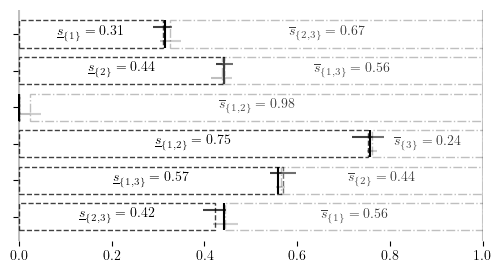

In [13]:
fig,ax = pyplot.subplots(figsize=(6,3))
ax.grid(False)
for spine in ['top','left','right','bottom']: ax.spines[spine].set_visible(False)
width = .75
ax.errorbar(fmt='none',color='k',
    x = 1-si_total_true,
    y = np.arange(len(si_closed)),
    xerr = 0,
    yerr = width/2,
    alpha = 1)
bar_closed = ax.barh(np.arange(len(si_closed)),np.flip(si_closed),width,label='Closed SI',color='w',edgecolor='k',alpha=.75,linestyle='--')
ax.errorbar(fmt='none',color='k',
    x = si_closed,
    y = np.flip(np.arange(len(si_closed)))+width/4,
    xerr = np.vstack((si_closed-ci_comb_low_closed,ci_comb_high_closed-si_closed)),
    yerr = 0,
    #elinewidth = 5,
    alpha = .75)
bar_total = ax.barh(np.arange(len(si_closed)),si_total,width,label='Total SI',color='w',alpha=.25,edgecolor='k',left=1-si_total,zorder=10,linestyle='-.')
ax.errorbar(fmt='none',color='k',
    x = 1-si_total,
    y = np.arange(len(si_closed))-width/4,
    xerr = np.vstack((si_total-ci_comb_low_total,ci_comb_high_total-si_total)),
    yerr = 0,
    #elinewidth = 5,
    alpha = .25)
closed_labels = [r'$\underline{s}_{\{%s\}} = %.2f$'%(','.join([str(i+1) for i in idx]),c) for idx,c in zip(idxs[::-1],np.flip(si_closed))]
closed_labels[3] = ''
total_labels = [r'$\overline{s}_{\{%s\}} = %.2f$'%(','.join([str(i+1) for i in idx]),t) for idx,t in zip(idxs,si_total)]
ax.bar_label(bar_closed,label_type='center',labels=closed_labels)
ax.bar_label(bar_total,label_type='center',labels=total_labels)
ax.set_xlim([-.001,1.001])
ax.axvline(x=0,ymin=0,ymax=len(si_closed),color='k',alpha=.25)
ax.axvline(x=1,ymin=0,ymax=len(si_closed),color='k',alpha=.25)
ax.set_yticklabels([])
if root: fig.savefig(root+'ishigami.pdf',transparent=True)

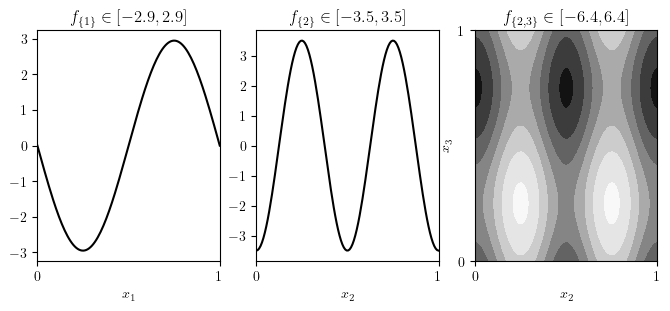

In [14]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(8,3))
x_1d = np.linspace(0,1,num=128)
x_1d_mat = np.tile(x_1d,(3,1)).T
y_1d = qp.Ishigami._exact_fu_functions(x_1d_mat,indices=[[0],[1],[2]],a=a,b=b)
for i in range(2):
    ax[i].plot(x_1d,y_1d[:,i],color='k')
    ax[i].set_xlim([0,1])
    ax[i].set_xticks([0,1])
    ax[i].set_xlabel(r'$x_{%d}$'%(i+1))
    ax[i].set_title(r'$f_{\{%d\}} \in [%.1f,%.1f]$'%(i+1,y_1d[:,i].min(),y_1d[:,i].max()))
x_mesh,y_mesh = np.meshgrid(x_1d,x_1d)
xquery = np.zeros((x_mesh.size,3))
for i,idx in enumerate([[1,2]]): # [[0,1],[0,2],[1,2]]
    xquery[:,idx[0]] = x_mesh.flatten()
    xquery[:,idx[1]] = y_mesh.flatten()
    zquery = qp.Ishigami._exact_fu_functions(xquery,indices=[idx],a=a,b=b)
    z_mesh = zquery.reshape(x_mesh.shape)
    ax[2+i].contourf(x_mesh,y_mesh,z_mesh,cmap=cm.Greys_r)
    ax[2+i].set_xlabel(r'$x_{%d}$'%(idx[0]+1))
    ax[2+i].set_ylabel(r'$x_{%d}$'%(idx[1]+1))
    ax[2+i].set_title(r'$f_{\{%d,%d\}} \in [%.1f,%.1f]$'%(tuple([i+1 for i in idx])+(z_mesh.min(),z_mesh.max())))
    ax[2+i].set_xlim([0,1])
    ax[2+i].set_ylim([0,1])
    ax[2+i].set_xticks([0,1])
    ax[2+i].set_yticks([0,1])
if root: fig.savefig(root+'ishigami_fu.pdf')

### Neural Network

In [15]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
data = load_iris()
feature_names = data["feature_names"]
feature_names = [fn.replace('sepal ','S')\
    .replace('length ','L')\
    .replace('petal ','P')\
    .replace('width ','W')\
    .replace('(cm)','') for fn in feature_names]
target_names = data["target_names"]
xt,xv,yt,yv = train_test_split(data["data"],data["target"],
    test_size = 1/3,
    random_state = 7)

In [16]:
mlpc = MLPClassifier(random_state=7,max_iter=1024).fit(xt,yt)
yhat = mlpc.predict(xv)
print("accuracy: %.1f%%"%(100*(yv==yhat).mean()))
# accuracy: 98.0%
sampler = qp.DigitalNetB2(4,seed=7)
true_measure =  qp.Uniform(sampler,
    lower_bound = xt.min(0),
    upper_bound = xt.max(0))
fun = qp.CustomFun(
    true_measure = true_measure,
    g = lambda x,compute_flags: mlpc.predict_proba(x),
    dimension_indv = 3)
si_fun = qp.SensitivityIndices(fun,indices="all")
qmc_algo = qp.CubQMCNetG(si_fun,abs_tol=.005)
nn_sis,nn_sis_data = qmc_algo.integrate()

accuracy: 98.0%


In [17]:
#print(nn_sis_data.flags_indv.shape)
#print(nn_sis_data.flags_comb.shape)
print('samples: 2^(%d)'%np.log2(nn_sis_data.n_total))
print('time: %.1e'%nn_sis_data.time_integrate)
print('indices:',nn_sis_data.integrand.indices)

import pandas as pd

df_closed = pd.DataFrame(nn_sis[0],columns=target_names,index=[str(idx) for idx in nn_sis_data.integrand.indices])
print('\nClosed Indices')
print(df_closed)
df_total = pd.DataFrame(nn_sis[1],columns=target_names,index=[str(idx) for idx in nn_sis_data.integrand.indices])
print('\nTotal Indices')
print(df_total)
df_closed_singletons = df_closed.T.iloc[:,:4]
df_closed_singletons['sum singletons'] = df_closed_singletons[['[%d]'%i for i in range(4)]].sum(1)
df_closed_singletons.columns = data['feature_names']+['sum']
df_closed_singletons = df_closed_singletons*100

import warnings
warnings.simplefilter('ignore',FutureWarning)
#if root: df_closed_singletons.to_latex(root+'si_singletons_closed.tex',float_format='%.1f%%')

samples: 2^(15)
time: 2.9e+00
indices: [[0], [1], [2], [3], [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3], [0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

Closed Indices
             setosa  versicolor  virginica
[0]        0.001504    0.071122   0.081736
[1]        0.058743    0.022073   0.010373
[2]        0.713777    0.328313   0.500059
[3]        0.046053    0.021077   0.120233
[0, 1]     0.059178    0.091764   0.098233
[0, 2]     0.715117    0.460138   0.642551
[0, 3]     0.046859    0.092322   0.207724
[1, 2]     0.843241    0.434629   0.520469
[1, 3]     0.108872    0.039572   0.127844
[2, 3]     0.823394    0.582389   0.705354
[0, 1, 2]  0.845359    0.570022   0.661100
[0, 1, 3]  0.108503    0.106081   0.218971
[0, 2, 3]  0.825389    0.814286   0.948331
[1, 2, 3]  0.996483    0.738213   0.729940

Total Indices
             setosa  versicolor  virginica
[0]        0.003199    0.259762   0.265085
[1]        0.172391    0.183159   0.045582
[2]        0.889677    0.896874   0.780377


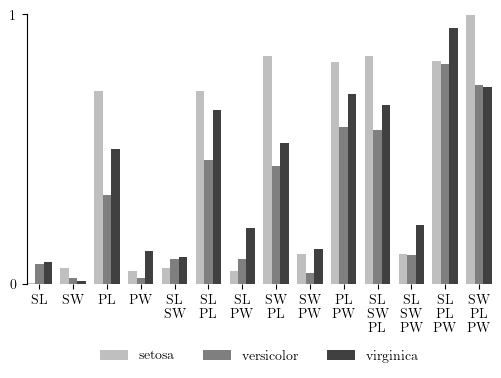

In [18]:
nindices = len(nn_sis_data.integrand.indices)
fig,ax = pyplot.subplots(figsize=(6,3.5))
ticks = np.arange(nindices)
width = .25
for i,(alpha,species) in enumerate(zip([.25,.5,.75],data['target_names'])):
    cvals = df_closed[species].to_numpy()
    tvals = df_total[species].to_numpy()
    ticks_i = ticks+i*width
    ax.bar(ticks_i,cvals,width=width,align='edge',color='k',alpha=alpha,label=species)
    #ax.bar(ticks_i,np.flip(tvals),width=width,align='edge',bottom=1-np.flip(tvals),color=color,alpha=.1)
ax.set_xlim([0,13+3*width])
ax.set_xticks(ticks+1.5*width)

# closed_labels = [r'$\underline{s}_{\{%s\}}$'%(','.join([r'\text{%s}'%feature_names[i] for i in idx])) for idx in nn_sis_data.integrand.indices]
closed_labels = ['\n'.join([feature_names[i] for i in idx]) for idx in nn_sis_data.integrand.indices]
ax.set_xticklabels(closed_labels,rotation=0)
ax.set_ylim([0,1]); ax.set_yticks([0,1])
ax.grid(False)
for spine in ['top','right','bottom']: ax.spines[spine].set_visible(False)
ax.legend(frameon=False,loc='upper center',bbox_to_anchor=(.5,-.2),ncol=3);
if root: fig.savefig(root+'nn_si.pdf')